In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#plt.style.use("ggplot")
plt.style.use('seaborn')
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
def im_read(im_width:int, im_height:int, encoding:str, n_examples:int):
  inputs = []
  outputs = []
  for i in range(1, n_examples + 1):
    inputs.append(cv2.resize(cv2.cvtColor(cv2.imread('in ' + str(i) + '.jpg'),
                                          getattr(cv2,'COLOR_BGR2' + encoding)),
                             (im_width, im_height))
                  / 255)
    outputs.append((cv2.resize(cv2.cvtColor(cv2.imread('out ' + str(i) + '.jpg'),
                                           cv2.COLOR_BGR2GRAY),
                              (im_width, im_height))
                  / 255).reshape(im_width, im_height, 1))
  return np.array(inputs), np.array(outputs)

In [12]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters,
               kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters,
               kernel_size=(kernel_size, kernel_size),
               kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [13]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

encodings = ['RGB', 'HSV', 'LAB', 'XYZ', 'YUV']

def check_encodings(encodings, n_samples=10, epoch=10):
  encodings_results = []
  im_height, im_width = 128, 128
  for encoding in encodings:
    inputs, outputs = im_read(im_height, im_width,
                              encoding,
                              n_samples)
    X_train, X_valid, y_train, y_valid = train_test_split(inputs, outputs,
                                                          test_size=0.2, random_state=2018)
    input_img = Input((im_height, im_width, 3),
                      name='img')
    model = get_unet(input_img, 
                     n_filters=16,
                     dropout=0.05,
                     batchnorm=False)
    model.compile(optimizer=Adam(),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.BinaryCrossentropy()])
    result = model.fit(X_train, y_train,
                       epochs=epoch,
                       verbose=0,
                       validation_data=(X_valid, y_valid))
    encodings_results.append(result)
    print(encoding + " pass")
  return encodings_results
  
# plot encodings
def encodings_learning_curve(history, labels, title, save=False): #################
  colors = ['b', 'g', 'c', 'y', 'm']
  fig = plt.figure(figsize=(8,6))
  for i in range(len(history)):
    plt.plot([1 - loss for loss in history[i].history["loss"]],
            colors[i] + '--',
            label=labels[i] + ' train')
    plt.plot([1 - val_loss for val_loss in history[i].history["val_loss"]],
            colors[i],
            label=labels[i] + ' test')
  plt.title(title)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.ylim(0, 1)
  plt.legend(loc='lower right', 
             prop={'size': 15}, 
             fontsize='xx-large',
             ncol=2,handleheight=2.4,
             labelspacing=0.05)
  if save:
    plt.savefig(title + '_epoch_l_c.png', dpi=300)

enc_res = check_encodings(encodings, n_samples=16, epoch=40)

RGB pass
HSV pass
LAB pass
XYZ pass
YUV pass


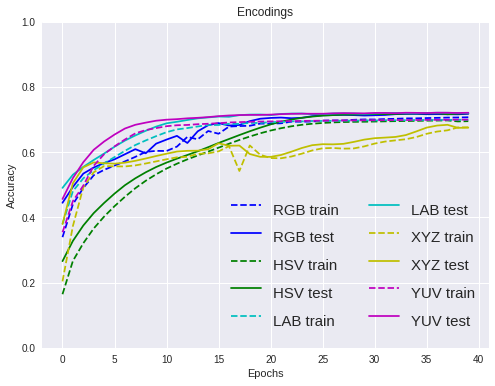

In [ ]:
encodings_learning_curve(enc_res, encodings, "Encodings", save=False)

In [ ]:
def KFold(inputs=None, outputs=None,  model=None, k_block=5, epoch=50, verbose=True):
  set_length = len(inputs)
  step_length = int(set_length/k_block)
  train_scores = []
  test_scores = []
  for index in range(k_block):
    x_test = np.array(inputs[index*step_length:step_length*index + step_length])
    y_test = np.array(outputs[index*step_length:step_length*index + step_length])
    x_train = np.array(inputs[0:index*step_length] + inputs[step_length*index + step_length:set_length])
    y_train = np.array(outputs[0:index*step_length] + outputs[step_length*index + step_length:set_length])
    input_img = Input((128, 128, 3), name='img')
    model = get_unet(input_img,
                     n_filters=16,
                     dropout=0.05,
                     batchnorm=False)
    model.compile(optimizer=Adam(),
                  loss="binary_crossentropy", 
                  metrics=[tf.keras.metrics.BinaryCrossentropy()])
    fit_model = model.fit(x_train, y_train,
                    epochs=epoch,
                    verbose=verbose,
                    validation_data=(x_test, y_test))
    train_scores.append(1 - fit_model.history["loss"][-1])
    test_scores.append(1 - fit_model.history["val_loss"][-1])
    if verbose:
      print("Block: 1, test accuracy : {0}, train accuracy : {1}\n".format(test_scores[-1],
                                                                           train_scores[-1]))
  if verbose:
    print("Cross-validation accuracy: ", np.mean(test_scores))
  return train_scores, test_scores

In [ ]:
def num_examples_learning_curve(param_range, k_block=5, epoch=15):
  length = len(param_range)
  train_score = [None]*length
  test_score = [None]*length
  for itter in range(length):
    inputs, outputs = im_read(128, 128,
                              "HSV",
                              param_range[itter])
    train_scores, test_scores = KFold(list(inputs),
                                      list(outputs),
                                      k_block=k_block, 
                                      epoch=epoch,
                                      verbose=0)
    
    train_score[itter] = train_scores
    test_score[itter] = test_scores
    #print("Pass " + str(itter) + " examples")
  return train_score, test_score

param_range = list(range(10, 16))

t_score, v_score = num_examples_learning_curve(param_range, k_block=5, epoch=1)

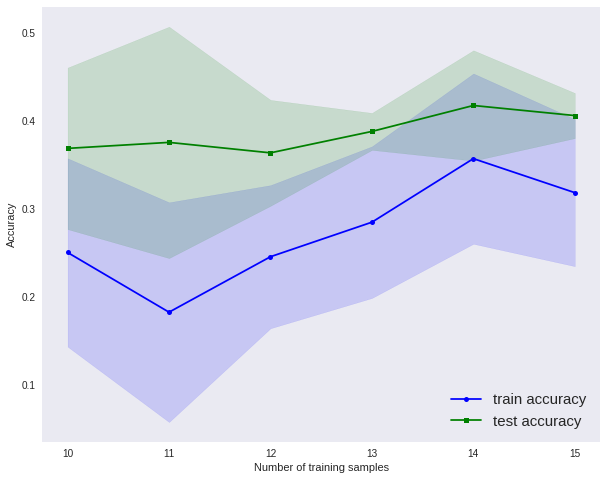

In [ ]:
def plot_learning_curve(train_scores, test_scores, param_name, param_range):
  #train_scores.shape = [n_param_value][k_accuracy_values]

  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  plt.figure(figsize=(10, 8))
  plt.plot(param_range,
          train_mean,
          color='blue',
          marker='o',
          markersize=5,
          label='train accuracy')
  plt.fill_between(param_range,
                  train_mean + train_std,
                  train_mean - train_std,
                  alpha=0.15,
                  color="blue")
  plt.plot(param_range,
          test_mean,
          color='green',
          marker='s',
          markersize=5,
          label='test accuracy')
  plt.fill_between(param_range,
                  test_mean + test_std,
                  test_mean - test_std,
                  alpha=0.15,
                  color='green')
  plt.grid()
  plt.legend(loc='lower right', prop={'size': 15})
  plt.xlabel(param_name)
  plt.ylabel("Accuracy")
  #plt.ylim(0.5, 0.8)
  plt.savefig('LC_num_samples.png', dpi=300)
  plt.show()

plot_learning_curve(t_score, v_score, "Number of training samples", param_range)

In [14]:
im_height = 128
im_width = 128

input_img = Input((im_height, im_width, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=False)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryCrossentropy()])

In [15]:
inputs, outputs = im_read(128, 128, "HSV", 16)
X_train, X_valid, y_train, y_valid = train_test_split(inputs, outputs, test_size=0.2, random_state=2018)

In [16]:
results = model.fit(X_train, y_train, epochs=100,
                   validation_data=(X_valid, y_valid))

Epoch 1/100
1/1 [==============================] - 0s 496ms/step - loss: 0.5460 - binary_crossentropy: 0.5460 - val_loss: 0.4889 - val_binary_crossentropy: 0.4889
Epoch 2/100
1/1 [==============================] - 0s 195ms/step - loss: 0.4914 - binary_crossentropy: 0.4914 - val_loss: 0.4474 - val_binary_crossentropy: 0.4474
Epoch 3/100
1/1 [==============================] - 0s 186ms/step - loss: 0.4493 - binary_crossentropy: 0.4493 - val_loss: 0.4095 - val_binary_crossentropy: 0.4095
Epoch 4/100
1/1 [==============================] - 0s 187ms/step - loss: 0.4110 - binary_crossentropy: 0.4110 - val_loss: 0.3767 - val_binary_crossentropy: 0.3767
Epoch 5/100
1/1 [==============================] - 0s 190ms/step - loss: 0.3788 - binary_crossentropy: 0.3788 - val_loss: 0.3482 - val_binary_crossentropy: 0.3482
Epoch 6/100
1/1 [==============================] - 0s 188ms/step - loss: 0.3526 - binary_crossentropy: 0.3526 - val_loss: 0.3251 - val_binary_crossentropy: 0.3251
Epoch 7/100
1/1 [=====

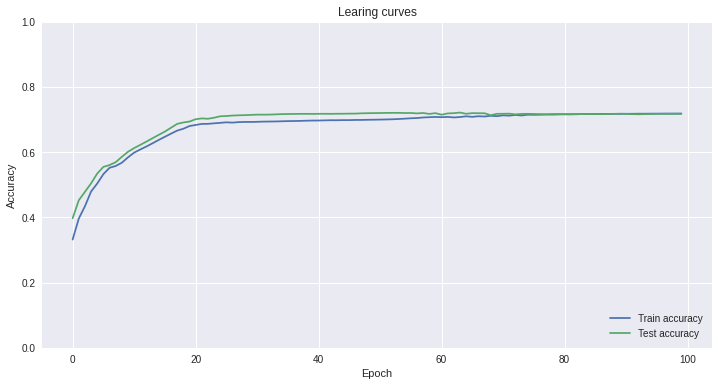

In [ ]:
def epoch_learning_curve(results):
  train = [1 - i for i in results.history["loss"]]
  test = [1 - i for i in results.history["val_loss"]]
  length = len(train)

  fig = plt.figure(figsize=(12,6))

  plt.plot(train, label='Train accuracy')
  plt.plot(test, label='Test accuracy')

  plt.title('Learing curves')
  plt.legend(loc='lower right')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.ylim(0, 1)
  #plt.savefig('LC.png', dpi=300)

epoch_learning_curve(results)

Text(0.5, 1.0, 'Output WB image')

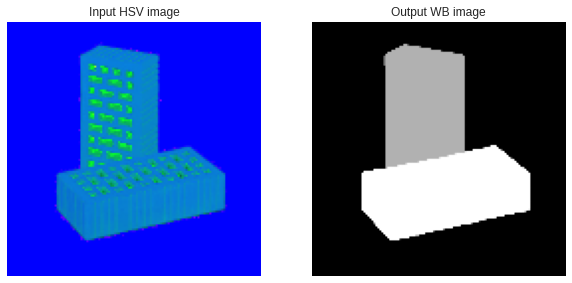

In [9]:
fig = plt.figure(figsize=(10, 6))

plt.subplot(121)
plt.imshow(X_train[0])
plt.axis('off')
plt.title('Input HSV image')

plt.subplot(122)
plt.imshow(y_train[0].reshape(128, 128))
plt.axis('off')
plt.title('Output WB image')
#plt.savefig('in out.png', dpi=300)

Text(0, 0.5, 'Number of pixels')

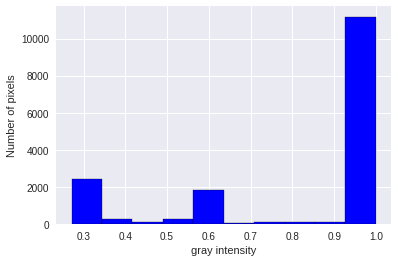

In [17]:
fig = plt.figure()
plt.hist(model.predict(X_train, verbose=0)[0].reshape(128*128),
         color = 'blue',
         edgecolor = 'black')
plt.xlabel('gray intensity')
plt.ylabel('Number of pixels')
#plt.savefig('hist.png', dpi=300)

In [ ]:
def show_results(test_data, model):
  preds = model.predict(test_data, verbose=0)
  length = len(test_data)
  for i in range(length):
    prediction = preds[i].reshape(128*128)
    color_image = np.zeros((128*128, 3))
    for pixel in range(128*128):
      if prediction[pixel] > 0.9:
        color_image[pixel] = np.array((1,
                                       1,
                                       1))
        #color_image[pixel] = np.array(1)
      if prediction[pixel] > 0.45 and prediction[pixel] < 0.9:
        color_image[pixel] = np.array((0.09019607843137255,
                                       0.7450980392156863,
                                       0.8117647058823529))
        #color_image[pixel] = np.array(0.29803922)
        
      if prediction[pixel] < 0.45:
        color_image[pixel] = np.array((0.9058823529411765,
                                       0.5411764705882353,
                                       0.7647058823529411))
        #color_image[pixel] = np.array(0)
    fig = plt.figure(figsize=(12,6))
    plt.gray()
    plt.subplot(131)
    plt.imshow(test_data[i].reshape(128, 128, 3))
    plt.title('Input image')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(preds[i].reshape(128, 128))
    plt.title('Output image')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow((color_image.reshape(128, 128, 3) * 255).astype(np.uint8))
    plt.title('Repaint')
    plt.axis('off')
    #plt.savefig('path.png', dpi=300)

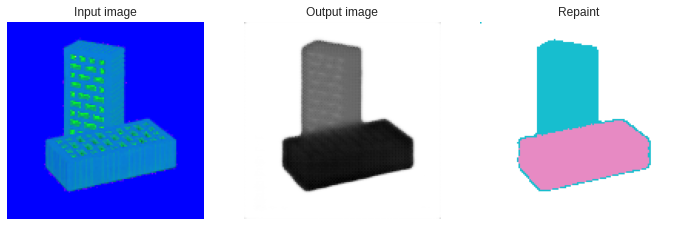

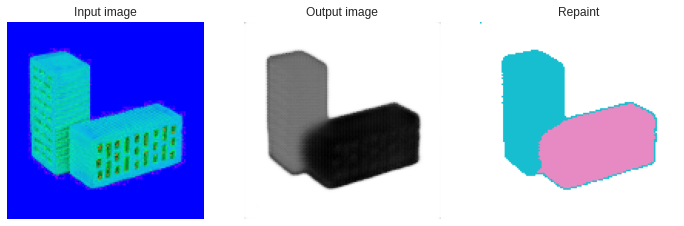

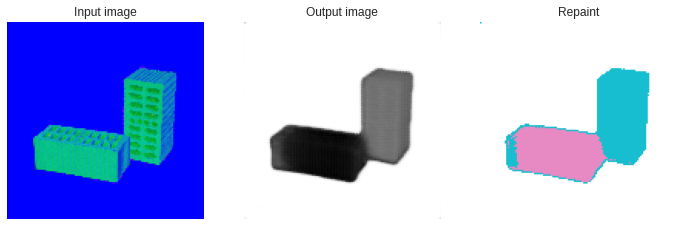

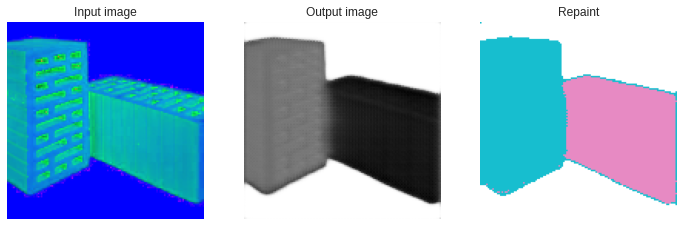

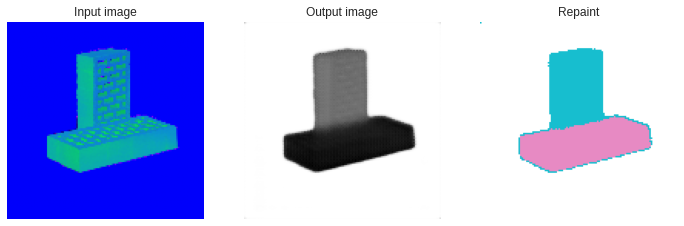

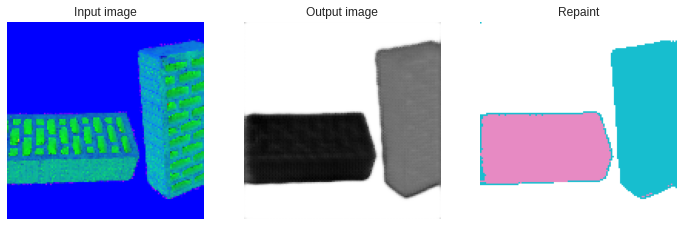

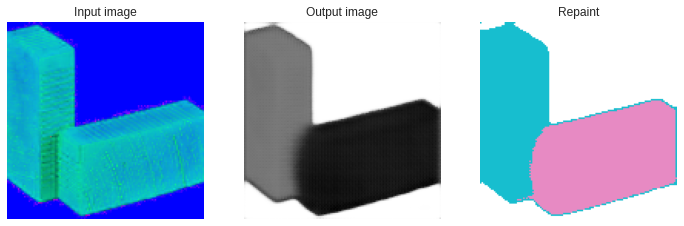

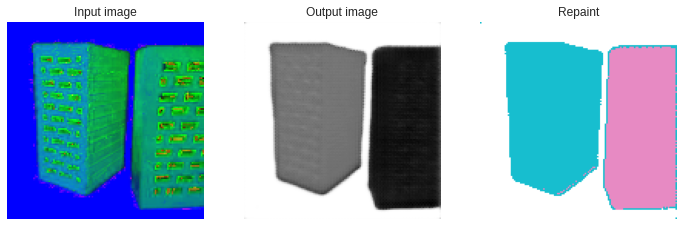

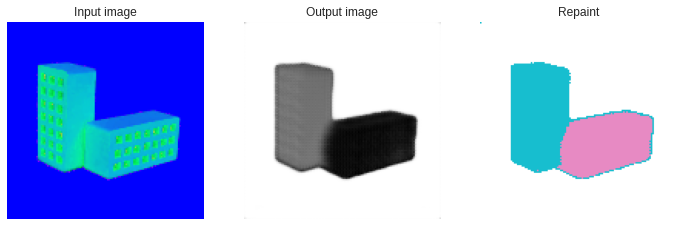

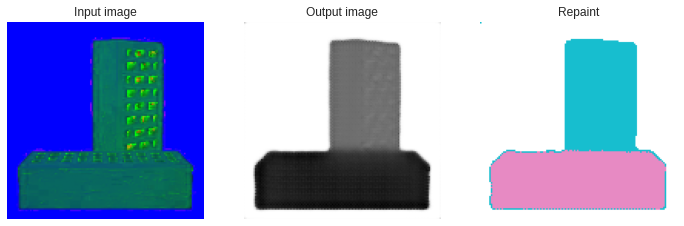

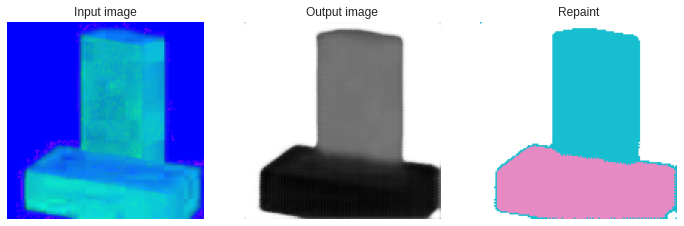

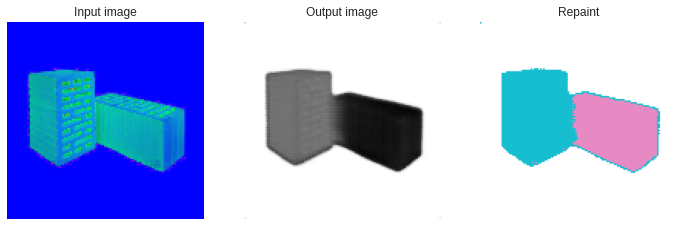

In [ ]:
show_results(X_train, model)

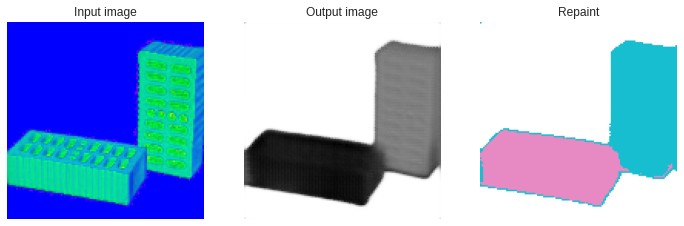

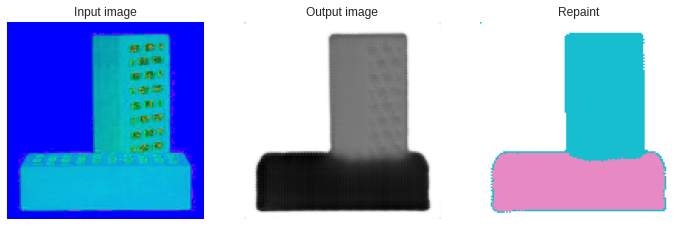

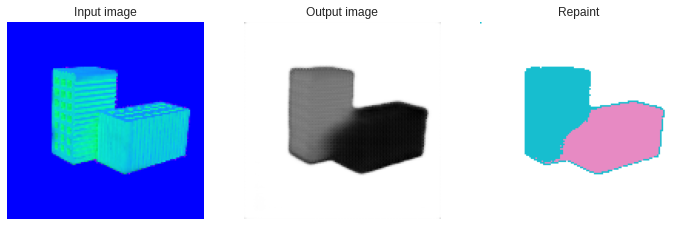

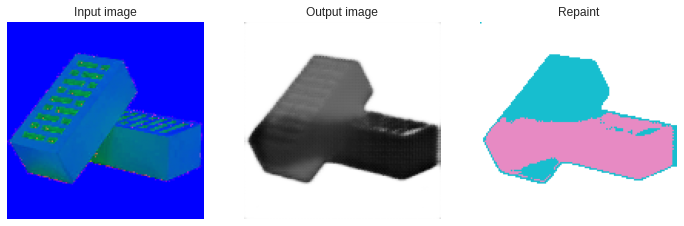

In [ ]:
show_results(X_valid, model)